# 3: Assessing model performance and applicability

Author: Daniel Lusk

## Imports

In [1]:
import ast
import pandas as pd
import xgboost as xgb

NOTEBOOK = True

if NOTEBOOK:
    %load_ext autoreload
    %autoreload 2

## Model performance

In [2]:
# Load a model
results = pd.read_csv("./results/training_results.csv").copy()
results.head(2)

,Run ID,Response variable,Predictor datasets,Resolution,Best parameters,N tuning iters,CV nRMSE,CV nRMSE STD,CV r-squared,CV r-squared STD,...,Predictor importance,Model file,N CV groups,CV grid size [m],CV block buffer,Random seed,N observations,Optimizer,max_iter,Filtered RV outliers
0,2023-06-19_19-57-20,iNat_Conduit.element.length_05deg_ln,"['WC_BIO_0.5_deg', 'MOD09GA.061_1km_0.5_deg', ...",0.5_deg,"{'n_estimators': 1269, 'max_depth': 5, 'subsam...",200.0,0.293427,0.046752,0.179706,0.088989,...,"[['sur_refl_b03_mean_2001-01-01_0.5_deg', 0.01...",/DATA/lusk/thesis/traits/results/training/2023...,10.0,20.935404,0.0001,42.0,NaN,NaN,NaN,NaN
1,2023-06-19_19-57-20,iNat_Dispersal.unit.length_05deg_ln,"['WC_BIO_0.5_deg', 'MOD09GA.061_1km_0.5_deg', ...",0.5_deg,"{'n_estimators': 222, 'max_depth': 4, 'subsamp...",200.0,0.347484,0.067841,0.052823,0.036950,...,"[['wc2.1_0.5_deg_bio_4', 0.01925615780055523],...",/DATA/lusk/thesis/traits/results/training/2023...,10.0,20.935404,0.0001,42.0,NaN,NaN,NaN,NaN


In [3]:
gbif_ssd_name = "GBIF_TRYgapfilled_X4_05deg"
# inat_ssd_name = "iNat_SSD_05deg_expln"
predictor_datasets = "['WC_BIO_0.5_deg', 'MOD09GA.061_1km_0.5_deg', 'ISRIC_soil_0.5_deg', 'VODCA_0.5_deg']"
resolution = "0.5_deg"

Get the training run data from the results dataframe

In [5]:
gbif_ssd_results = results.loc[
    (results["Response variable"] == gbif_ssd_name)
    & (results["Predictor datasets"] == predictor_datasets)
    & (results["Resolution"] == resolution)
]

Load the model with the best params

In [6]:
from dataclasses import dataclass
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

from utils.datasets import DataCollection, Dataset, MLCollection
import seaborn as sns


@dataclass
class Stats:
    cv_nrmse: float
    cv_nrmse_std: float
    cv_r2: float
    cv_r2_std: float
    test_r2: float
    predictor_importances: list


@dataclass
class Model:
    id: int
    run_id: str
    y_name: str
    Xy: MLCollection
    resolution: float
    params: dict
    n_tuning_iters: int
    stats: Stats
    model_fpath: str
    random_state: int
    train_test_split: float
    n_cv_groups: int
    cv_grid_size: float
    cv_block_buffer: float
    n_observations: int
    optimizer: str
    max_iter: int
    filtered_y_outliers: list

    def __post_init__(self):
        tt_splits = train_test_split(
            self.Xy.df[self.Xy.X.cols].to_numpy(),
            self.Xy.df[self.Xy.Y.cols].to_numpy(),
            self.Xy.coords,
            test_size=self.train_test_split,
            random_state=self.random_state,
        )
        self.X_train = tt_splits[0]
        self.X_test = tt_splits[1]
        self.y_train = tt_splits[2]
        self.y_test = tt_splits[3]
        self.coords_train = tt_splits[4]
        self.coords_test = tt_splits[5]
    
    @property
    def model(self):
        model = xgb.XGBRegressor(**self.params)
        model.load_model(self.model_fpath)
        return model

    def plot_observed_vs_predicted(self):
        """Plot observed vs. predicted values."""
        pred = self.model.predict(self.X_test)
        obs = self.y_test

        # plot the observed vs. predicted values using seaborn
        sns.set_theme()
        sns.set_style("whitegrid")
        sns.set_context("paper")

        fig, ax = plt.subplots()
        p1 = min(min(pred), min(obs))
        p2 = max(max(pred), max(obs))
        ax.plot([p1, p2], [p1, p2], color="black", lw=0.5)
        ax.scatter(pred, obs)

        # set informative axes and title
        ax.set_xlabel("Predicted Values")
        ax.set_ylabel("Observed Values")
        ax.set_title(f"Observed vs. Predicted Values for\n{self.y_name}")
        plt.show()




    @classmethod
    def from_results_row(cls, row: pd.Series):
        dataset_ids = ast.literal_eval(row["Predictor datasets"])
        X = DataCollection([Dataset.from_id(id) for id in dataset_ids])
        y = DataCollection([Dataset.from_stem(row["Response variable"])])
        Xy = MLCollection(X, y)
        Xy.drop_NAs(verbose=1)

        stats = Stats(
            cv_nrmse=row["CV nRMSE"],
            cv_nrmse_std=row["CV nRMSE STD"],
            cv_r2=row["CV r-squared"],
            cv_r2_std=row["CV r-squared STD"],
            test_r2=row["Test r-squared"],
            predictor_importances=ast.literal_eval(row["Predictor importance"]),
        )

        return cls(
            id=int(row.name.__str__()),
            run_id=row["Run ID"],
            y_name=row["Response variable"],
            Xy=Xy,
            resolution=row["Resolution"],
            params=ast.literal_eval(row["Best parameters"]),
            n_tuning_iters=int(row["N tuning iters"]),
            stats=stats,
            model_fpath=row["Model file"],
            random_state=int(row["Random seed"]),
            train_test_split=42,  # TODO: add to results
            n_cv_groups=int(row["N CV groups"]),
            cv_grid_size=row["CV grid size [m]"],
            cv_block_buffer=row["CV block buffer"],
            n_observations=int(row["N observations"]),
            optimizer=row["Optimizer"],
            max_iter=int(row["max_iter"]),
            filtered_y_outliers=ast.literal_eval(row["Filtered RV outliers"]),
        )


@dataclass
class Trait:
    name: str
    models: list[Model]

/DATA/lusk/thesis/traits/utils/datasets.py:11: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [7]:
row = gbif_ssd_results.iloc[0]

In [8]:
model = Model.from_results_row(row)

XY shape before dropping full-NA rows/cols: (259200, 234)
XY shape after:                             (35595, 233)
# of rows excluded: 223605 (86.27%)
Empty columns:
X: ['soc_60-100cm_mean_0.5_deg']
Y: []


In [28]:
del min
del max

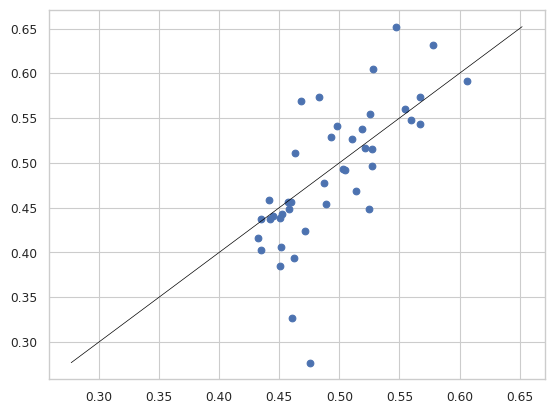

In [40]:
pred = model.model.predict(model.X_test)
obs = model.y_test

import matplotlib.pyplot as plt


# plot the observed vs. predicted values using seaborn
sns.set_theme()
sns.set_style("whitegrid")
sns.set_context("paper")


fig, ax = plt.subplots()
p1 = min(min(pred), min(obs))
p2 = max(max(pred), max(obs))
ax.plot([p1, p2], [p1, p2], color="black", lw=0.5)
ax.scatter(pred, obs)
